In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import os

In [2]:
input_path = r'C:\Users\Parthasarathy.Harini\Downloads\NLP\traffic.csv'


In [3]:
df = pd.read_csv(input_path)

# Display basic information about the dataset
print(df.head())
print(df.info())


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


In [4]:
# Convert datetime to proper format
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# Extract time-based features
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['year'] = df['DateTime'].dt.year

# Check data distribution by junction
junction_counts = df.groupby('Junction').size()
print("Data points per junction:")
print(junction_counts)

# Split data by time (2015-2016 for training, 2017 for validation)
train_data = df[df['DateTime'].dt.year < 2017].copy()
val_data = df[df['DateTime'].dt.year == 2017].copy()

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# Check if we have validation data for each junction
val_junction_counts = val_data.groupby('Junction').size()
print("Validation data points per junction:")
print(val_junction_counts)

# Normalize the data
scaler = MinMaxScaler()
df['Vehicles_scaled'] = scaler.fit_transform(df[['Vehicles']])
train_data['Vehicles_scaled'] = scaler.transform(train_data[['Vehicles']])
val_data['Vehicles_scaled'] = scaler.transform(val_data[['Vehicles']])


Data points per junction:
Junction
1    14592
2    14592
3    14592
4     4344
dtype: int64
Training data shape: (30744, 8)
Validation data shape: (17376, 8)
Validation data points per junction:
Junction
1    4344
2    4344
3    4344
4    4344
dtype: int64


In [5]:
# Function to create sequences for time series prediction
def create_sequences(data, junction_id, seq_length=24):
    """
    Create sequences of data for a specific junction with a given sequence length.
    """
    junction_data = data[data['Junction'] == junction_id].copy()
    junction_data = junction_data.sort_values('DateTime')

    # Check if we have enough data to create sequences
    if len(junction_data) <= seq_length:
        print(f"Warning: Junction {junction_id} has only {len(junction_data)} data points, which is not enough to create sequences of length {seq_length}")
        return np.array([]), np.array([])

    X, y = [], []
    for i in range(len(junction_data) - seq_length):
        X.append(junction_data['Vehicles_scaled'].iloc[i:i+seq_length].values)
        y.append(junction_data['Vehicles_scaled'].iloc[i+seq_length])

    return np.array(X), np.array(y)

# Create sequences for each junction
junctions = df['Junction'].unique()
X_train_all = []
y_train_all = []
X_val_all = []
y_val_all = []

for junction in junctions:
    X_train, y_train = create_sequences(train_data, junction)
    X_val, y_val = create_sequences(val_data, junction)

    # Only add non-empty sequences
    if X_train.size > 0 and y_train.size > 0:
        X_train_all.append(X_train)
        y_train_all.append(y_train)
        print(f"Junction {junction} - Training sequences: {len(X_train)}")
    else:
        print(f"Junction {junction} - No training sequences created")

    if X_val.size > 0 and y_val.size > 0:
        X_val_all.append(X_val)
        y_val_all.append(y_val)
        print(f"Junction {junction} - Validation sequences: {len(X_val)}")
    else:
        print(f"Junction {junction} - No validation sequences created")

# Check if we have any sequences
if not X_train_all or not y_train_all or not X_val_all or not y_val_all:
    raise ValueError("No sequences were created. Please check your data.")

# Combine data from all junctions
X_train = np.vstack(X_train_all)
y_train = np.concatenate(y_train_all)
X_val = np.vstack(X_val_all)
y_val = np.concatenate(y_val_all)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Junction 1 - Training sequences: 10224
Junction 1 - Validation sequences: 4320
Junction 2 - Training sequences: 10224
Junction 2 - Validation sequences: 4320
Junction 3 - Training sequences: 10224
Junction 3 - Validation sequences: 4320
Junction 4 - No training sequences created
Junction 4 - Validation sequences: 4320
X_train shape: (30672, 24)
y_train shape: (30672,)
X_val shape: (17280, 24)
y_val shape: (17280,)


In [6]:
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        # Reshape X to add channel dimension: (samples, sequence_length) -> (samples, sequence_length, 1)
        X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
        self.X = torch.tensor(X_reshaped, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
train_dataset = TrafficDataset(X_train, y_train)
val_dataset = TrafficDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
class TrafficCNN(nn.Module):
    def __init__(self, seq_length):
        super(TrafficCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # Calculate the size after convolutions and pooling
        # Initial size: seq_length
        # After conv1 + padding: seq_length
        # After pool1: seq_length/2
        # After conv2 + padding: seq_length/2
        # After pool2: seq_length/4
        # After conv3 + padding: seq_length/4
        flattened_size = 128 * (seq_length // 4)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flattened_size, 64)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        # Input shape: (batch_size, seq_length, 1)
        # Need to reshape for conv1d: (batch_size, channels, seq_length)
        if x.dim() == 3:
            # If input has shape [batch, seq_len, 1]
            x = x.permute(0, 2, 1)
        else:
            # If there was an issue and input has shape [batch, seq_len]
            x = x.unsqueeze(1)  # Add channel dimension [batch, 1, seq_len]
        
        # Convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        
        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
seq_length = 24  # 24 hours of historical data
model = TrafficCNN(seq_length).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Print model summary
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Using device: cuda
TrafficCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=768, out_features=64, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 125569


Epoch 1/50 | Train Loss: 0.001094 | Val Loss: 0.001843 | Time: 4.81s
Epoch 2/50 | Train Loss: 0.000610 | Val Loss: 0.001783 | Time: 4.18s
Epoch 3/50 | Train Loss: 0.000579 | Val Loss: 0.000933 | Time: 4.13s
Epoch 4/50 | Train Loss: 0.000539 | Val Loss: 0.002303 | Time: 4.06s
Epoch 5/50 | Train Loss: 0.000530 | Val Loss: 0.002258 | Time: 3.96s
Epoch 6/50 | Train Loss: 0.000509 | Val Loss: 0.001250 | Time: 4.01s
Epoch 7/50 | Train Loss: 0.000496 | Val Loss: 0.001315 | Time: 4.07s
Epoch 8/50 | Train Loss: 0.000494 | Val Loss: 0.001536 | Time: 4.06s
Epoch 9/50 | Train Loss: 0.000492 | Val Loss: 0.002072 | Time: 3.98s
Epoch 10/50 | Train Loss: 0.000480 | Val Loss: 0.002098 | Time: 3.95s
Epoch 11/50 | Train Loss: 0.000470 | Val Loss: 0.001183 | Time: 3.97s
Epoch 12/50 | Train Loss: 0.000467 | Val Loss: 0.002654 | Time: 3.96s
Epoch 13/50 | Train Loss: 0.000469 | Val Loss: 0.002346 | Time: 3.95s
Early stopping at epoch 13


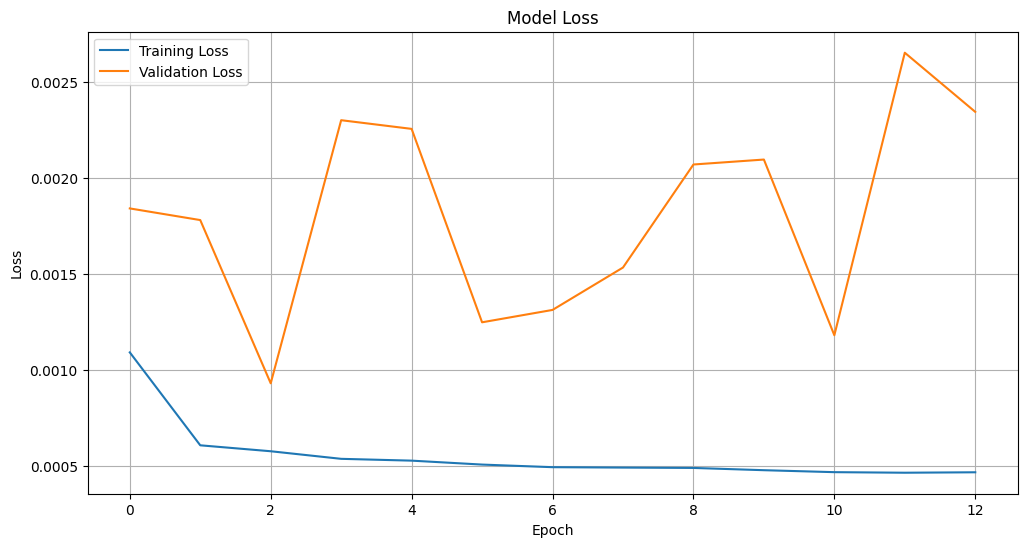

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Print statistics
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {epoch_time:.2f}s")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

# Train the model
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error: 75.18
Root Mean Squared Error: 8.67
R² Score: 0.8881


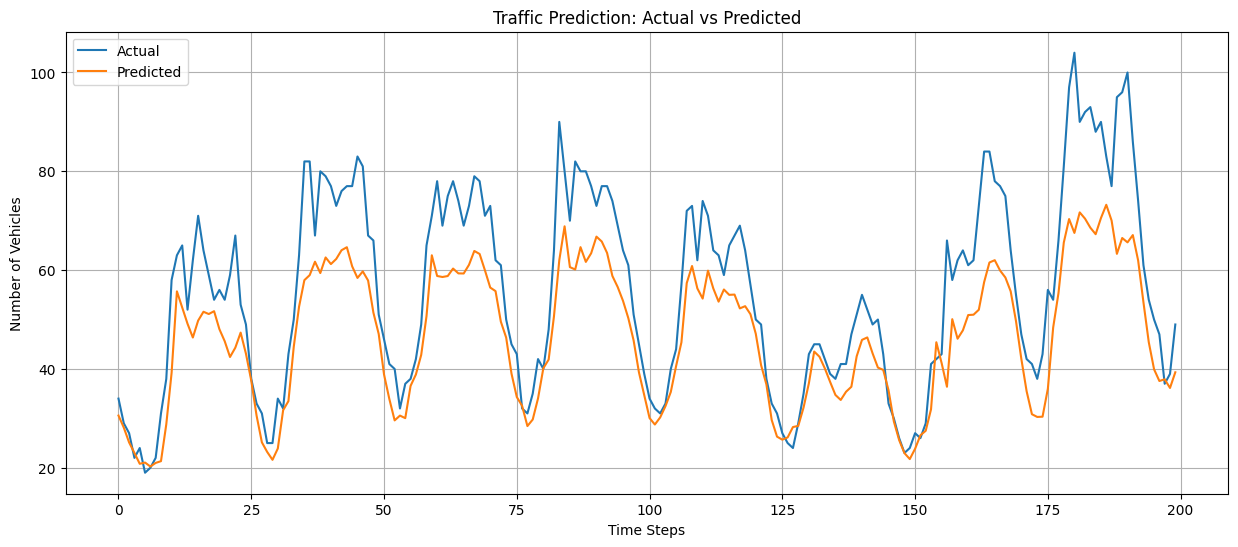

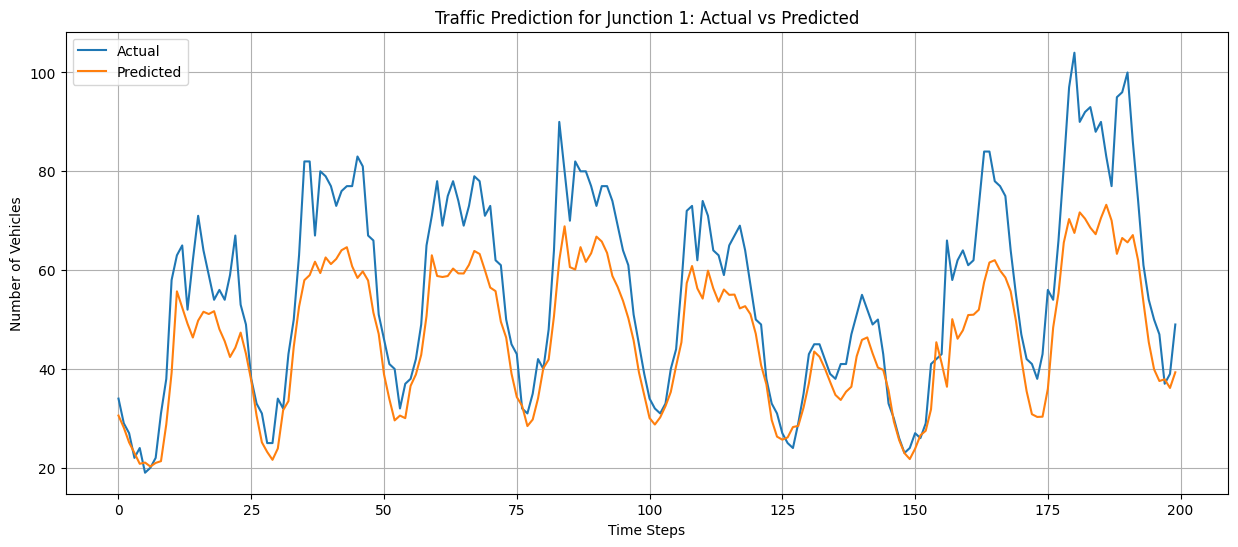

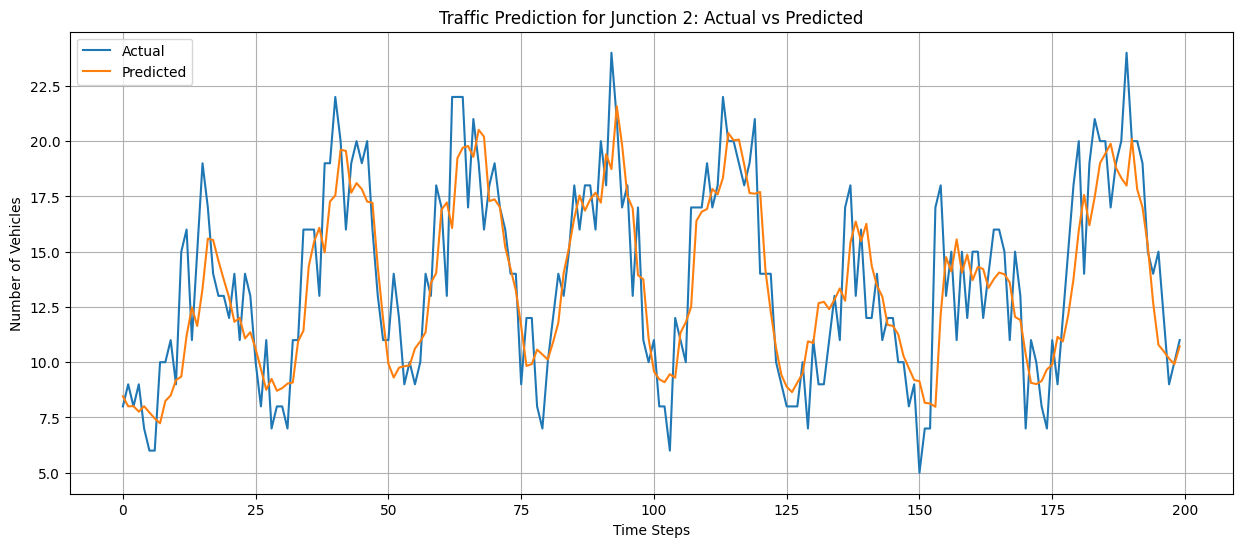

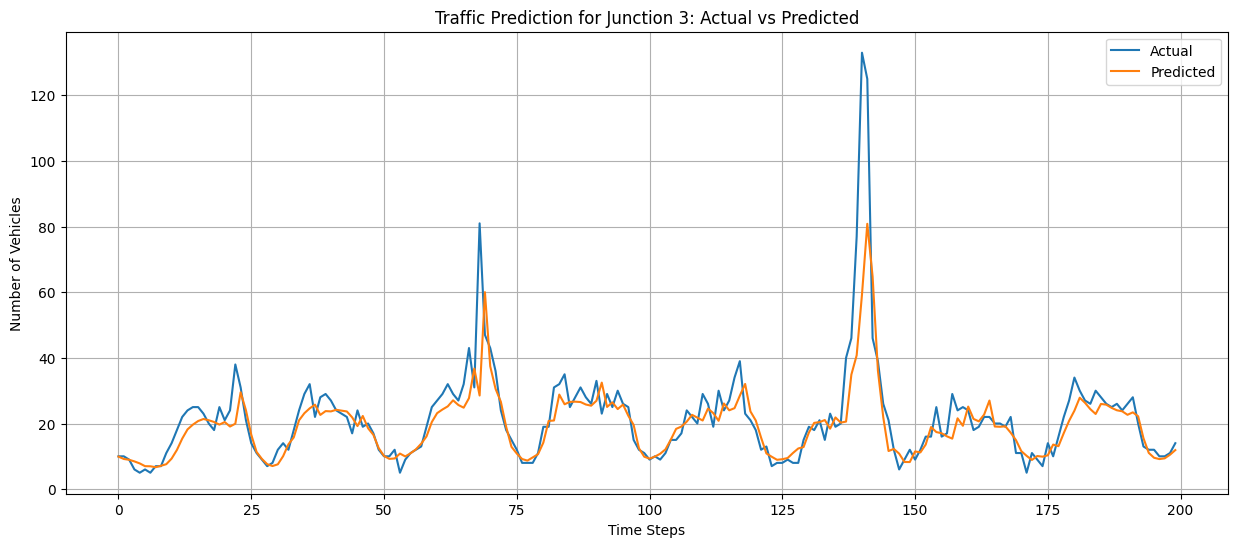

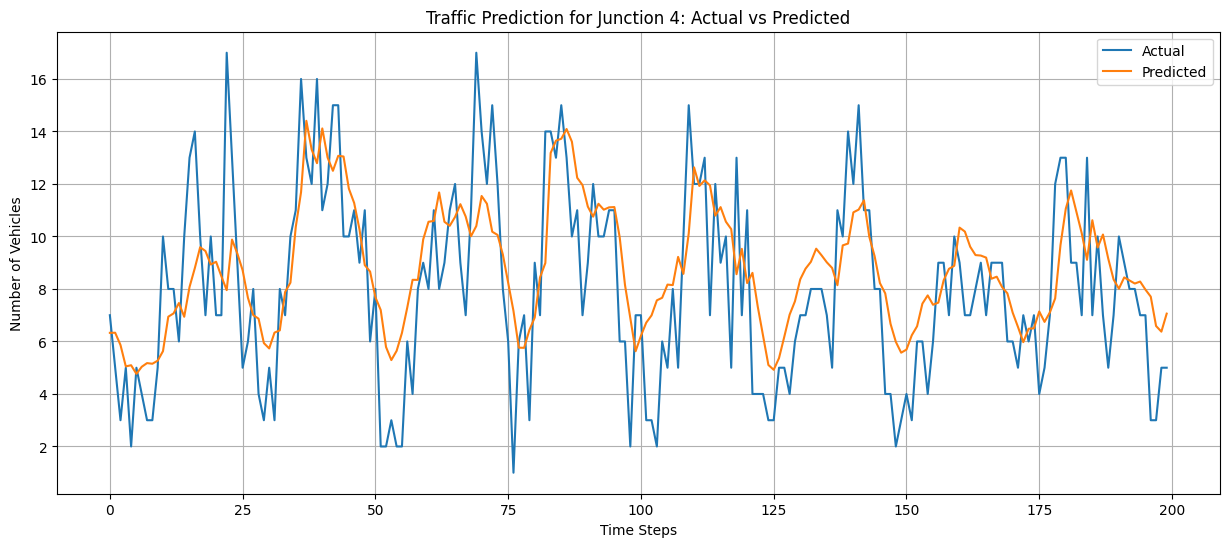

Model saved successfully.


In [11]:
model.eval()
predictions = []
actual_values = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actual_values.append(targets.cpu().numpy())

y_pred_scaled = np.vstack(predictions)
y_true_scaled = np.vstack(actual_values)

# Inverse transform to get actual vehicle counts
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_true_scaled)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_true[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title('Traffic Prediction: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

# Visualize predictions for each junction separately
# First, we need to track which sequences belong to which junction
junction_val_indices = {}
current_idx = 0

for i, junction in enumerate(junctions):
    if i < len(X_val_all):  # Make sure we have validation data for this junction
        junction_length = len(X_val_all[i])
        junction_val_indices[junction] = (current_idx, current_idx + junction_length)
        current_idx += junction_length

# Plot predictions for each junction
for junction, (start_idx, end_idx) in junction_val_indices.items():
    if end_idx > start_idx:  # Make sure we have data for this junction
        plt.figure(figsize=(15, 6))
        plt.plot(y_true[start_idx:start_idx+200], label='Actual')
        plt.plot(y_pred[start_idx:start_idx+200], label='Predicted')
        plt.title(f'Traffic Prediction for Junction {junction}: Actual vs Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel('Number of Vehicles')
        plt.legend()
        plt.grid(True)
        plt.show()

# Save the model
torch.save(model.state_dict(), 'traffic_cnn_model_pytorch.pth')
print("Model saved successfully.")


In [12]:
def predict_junction_traffic(model, junction_id, date_range, seq_length=24):
    """
    Predict traffic for a specific junction over a given date range.

    Parameters:
    model: Trained PyTorch model
    junction_id: ID of the junction
    date_range: pandas DatetimeIndex for prediction
    seq_length: Length of input sequence

    Returns:
    DataFrame with predictions
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get the most recent data for this junction
    junction_data = df[df['Junction'] == junction_id].copy()

    if len(junction_data) < seq_length:
        print(f"Warning: Not enough data for junction {junction_id}")
        return None

    last_sequence = junction_data['Vehicles_scaled'].iloc[-seq_length:].values

    predictions = []
    current_sequence = last_sequence.copy()

    with torch.no_grad():
        for _ in range(len(date_range)):
            # Reshape for prediction and convert to tensor
            current_sequence_tensor = torch.tensor(current_sequence.reshape(1, seq_length, 1), dtype=torch.float32).to(device)
            
            # Predict next value
            next_value = model(current_sequence_tensor).cpu().numpy()[0][0]
            predictions.append(next_value)
            
            # Update sequence
            current_sequence = np.append(current_sequence[1:], next_value)

    # Convert predictions back to original scale
    predictions_scaled = np.array(predictions).reshape(-1, 1)
    predictions_actual = scaler.inverse_transform(predictions_scaled)

    # Create result dataframe
    result_df = pd.DataFrame({
        'DateTime': date_range,
        'Junction': junction_id,
        'Predicted_Vehicles': predictions_actual.flatten()
    })

    return result_df

# Example usage of prediction function
"""
# Use 'h' instead of 'H' to avoid the deprecation warning
future_dates = pd.date_range(start='2018-01-01', periods=24, freq='h')
for junction in junctions:
    junction_predictions = predict_junction_traffic(model, junction, future_dates)
    if junction_predictions is not None:
        print(f"\nPredictions for Junction {junction}:")
        print(junction_predictions.head())
"""

# Cell 12: E

'\n# Use \'h\' instead of \'H\' to avoid the deprecation warning\nfuture_dates = pd.date_range(start=\'2018-01-01\', periods=24, freq=\'h\')\nfor junction in junctions:\n    junction_predictions = predict_junction_traffic(model, junction, future_dates)\n    if junction_predictions is not None:\n        print(f"\nPredictions for Junction {junction}:")\n        print(junction_predictions.head())\n'